# INFO371 Problem Set: Estimating Causal Effects with BA and CS methods

## Instructions

* Please write clearly! Answer each question in a way that if the code chunks are removed from your document, the result are still readable!
* Discussing the solutions and getting help is all right, but you have to solve the problem your own. Do not copy-paste from others!
* Make sure you show your work!

---

## Introduction

For this assignment, you will be using data from the Progresa program, a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "School subsidies for the poor: evaluating the Mexican Progresa poverty program", by Paul Shultz. Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to make you familiar with the simple
estimators that you are learning in class (cross-sectional and before-after), and to use those to measure the impact of Progresa on secondary school enrollment rates.
Your task is to estimate the impact of progresa subsidies on the school attendance.  Note: this means to estimate the causal effect.

## Background - About the PROGRESA program
In 1990s, Mexican government decided to improve the school attendance
of poor rural children by introducing a cash subsidy to families.
However, the families were only able to claim the money if a) they
were considered poor, and b) if their
children attended school.  Most importantly in the current
context, the subsidy was introduced in a randomized manner where
initially only certain villages were eligible for subsidies.  In this
problem set we analyze this time period where the subsidies
formed essentially a randomized
control trial.

The timeline of the program was:

* Baseline survey conducted in 1997
* Intervention--subsidies for _poor households_ in _treatment villages_ begins in 1998, wave 1 data was collected in 1998
* wave 2 data collected in 1999
* Evaluation ends in 2000, at which point all villages becomes eligible to the subsidy

Note that:
* the Progresa program was only available for poor families, so in the analysis below we only consider poor households
* The central variable here is _sc_, the dummy variable that tells if the child did attend the school or not

When you are ready, download the progresa-sample.csv data from Canvas. The dataset is from actual data collected to evaluate the impact of the Progresa program. In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are
surveyed in both years. The table below describes the variables
in the dataset: 


|Variable Name | Description| 
|:--- | :--- |
|year | year in which data is collected |
|sex | male = 1|
|indig | indigenous = 1|
|dist\_sec| nearest distance to a secondary school|
|sc | enrolled in school in year of survey (=1) |
|grc | grade enrolled |
|fam\_n | family size|
|min\_dist | min distance to an urban center|
|dist\_cap | min distance to the capital|
|poor | poor = "pobre", not poor = "no pobre"|
|progresa | treatment = "basal", control = "0"|
|hohedu | years of schooling of head of household|
|hohwag | monthly wages of head of household|
|welfare\_index| welfare index used to classify poor|
|hohsex | gender of head of household (male=1)|
|hohage | age of head of household|
|age | years old|
|folnum | individual id|
|village | village id|
|sc97 | enrolled in school in 1997 (=1)|

---
You can also view some summary statstics about the datset generated by the code below: 

In [62]:
import pandas as pd

prog_df = pd.read_csv('progresa-sample.csv')
prog_sub = prog_df.drop(labels=['year','folnum','village'], axis=1, inplace=False)
prog_df.dropna(subset=['sc'], inplace=True)
prog_sub.describe().loc[['mean','std']].T.sort_index()

,mean,std
age,11.366460,3.167744
dist_cap,147.674452,76.063134
dist_sec,2.418910,2.234109
fam_n,7.215715,2.352900
grc,3.963537,2.499063
grc97,3.705372,2.572387
hohage,44.436717,11.620372
hohedu,2.768104,2.656106
hohsex,0.925185,0.263095
hohwag,586.985312,788.133664



## Graphical Exploration (20 pts)
Before we get into regression, it is worthwhile to have visual image of the data.

1. Load the data (note - this is already done for you in the cell above. You may use that dataframe if you would like). How many cases do we have?  How many different villages?  How many cases of poor in progresa villages?



2. (4pt) Compute average schooling rate of poor household by villages (you can use village id as the [grouping](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) variable) for 1997 and 1998. Compare it between progresa villages, and in non-progresa villages in 1997 and 1998. Here just report the averages, you'll do a graphical comparison of distributions below.) 

    _Note: this asks you to compare the schooling rate __by village__, i.e. you need a single number (avg schooling rate) for each village.  Thereafter, you should compare__averages of village averages__._


3. (4pt) Display the average schooling rate before the program (1997) separately for progresa/non-progresa villages. Mark sample average rate (separately for progresa/non-progresa villages) on the figure. Attempt to overlay these density estimates.


4. (4pt) Repeat for the program year (1998)


5. Comment the results.  Do the distributions look similar?  Do you see the schooling rate in progresa villages increasing over that of the control villages?

In [22]:
# code goes here. 
# NOTE -- you may need to add multiple cells to answer all of the questions.
print("number of cases surveyed:", prog_df.shape[0])
print("number of unique villages:", len(prog_df.village.unique()))
in_p_poor = prog_df[(prog_df.poor == 'pobre') & (prog_df.progresa == 'basal')]
print("number of villages with poor members:", len(in_p_poor.village.unique()))
print()

year1_poor = prog_df[(prog_df.year == 97) & (prog_df.poor == 'pobre')]
grouped1 = year1_poor.groupby(['village', 'progresa'])
average_schooling_rate1 = grouped1['sc'].mean()
average_basal = average_schooling_rate1[average_schooling_rate1.index.get_level_values('progresa') == 'basal'].mean()
average_0 = average_schooling_rate1[average_schooling_rate1.index.get_level_values('progresa') == '0'].mean()
print("Average for poor household progresa entries 1997:", average_basal)
print("Average for poor household non-progress entries 1997:", average_0)
print()


year2_poor = prog_df[(prog_df.year == 98) & (prog_df.poor == 'pobre')]
grouped2 = year2_poor.groupby(['village', 'progresa'])
average_schooling_rate2 = grouped2['sc'].mean()
average_basal2 = average_schooling_rate2[average_schooling_rate2.index.get_level_values('progresa') == 'basal'].mean()
average_02 = average_schooling_rate2[average_schooling_rate2.index.get_level_values('progresa') == '0'].mean()
print("Average for poor household progresa entries 1998:", average_basal2)
print("Average for poor household non-progress entries 1998:", average_02)

number of cases surveyed: 68797
number of unique villages: 505
number of villages with poor members: 320

Average for poor household progresa entries 1997: 0.8138394110596501
Average for poor household non-progress entries 1997: 0.8137762497441701

Average for poor household progresa entries 1998: 0.8295362042630737
Average for poor household non-progress entries 1998: 0.8061845192878945


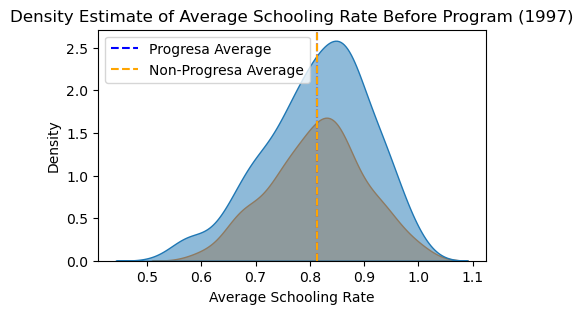

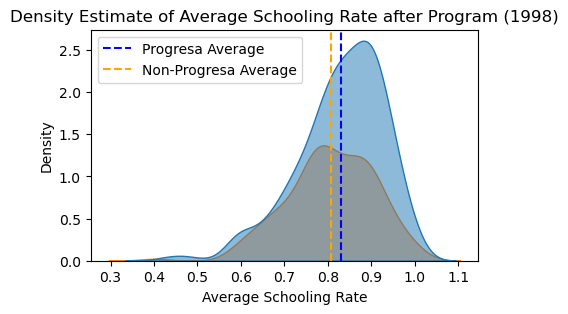

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
average_schooling_rate1 = grouped1['sc'].mean().reset_index()
plt.figure(figsize=(5, 3))
sns.kdeplot(data=average_schooling_rate1, x='sc', hue='progresa', fill=True, alpha=0.5)
plt.axvline(x=average_schooling_rate1[average_schooling_rate1['progresa'] == 'basal']['sc'].mean(), color='blue', linestyle='--', label='Progresa Average')
plt.axvline(x=average_schooling_rate1[average_schooling_rate1['progresa'] == '0']['sc'].mean(), color='orange', linestyle='--', label='Non-Progresa Average')
plt.legend()
plt.xlabel('Average Schooling Rate')
plt.title('Density Estimate of Average Schooling Rate Before Program (1997)')
plt.show()

average_schooling_rate2 = grouped2['sc'].mean().reset_index()
plt.figure(figsize=(5, 3))
sns.kdeplot(data=average_schooling_rate2, x='sc', hue='progresa', fill=True, alpha=0.5)
plt.axvline(x=average_schooling_rate2[average_schooling_rate2['progresa'] == 'basal']['sc'].mean(), color='blue', linestyle='--', label='Progresa Average')
plt.axvline(x=average_schooling_rate2[average_schooling_rate2['progresa'] == '0']['sc'].mean(), color='orange', linestyle='--', label='Non-Progresa Average')
plt.legend()
plt.xlabel('Average Schooling Rate')
plt.title('Density Estimate of Average Schooling Rate after Program (1998)')
plt.show()

The results of the analysis have a few key takeaways:

1. most villages (320) of the 505 total are poor and in the program
2. progresa and non-progresa poor households had functionally the same average schooling rate as seen in the first graph for before the program in 1997.
3. after the program in 1998 the progresa schooling group had higher rates than the non-progresa indicating a potential increase in attendence due to the payments.

The densitities themselves indicate that from 1997 to 1998 the amount of students enrollment per village increase which creates a greater left skew and draws the average to the right.

## Measuring impact

Next, we measure the impact of Progresa.  We do it in two ways: first
using the cross-sectional estimator, and thereafter by before-after estimator.
Both estimators we implement in turn in three ways:

* just table of averages
* simple regression where we only introduce control/treatment group (or time in case of before-after estimator)
* multiple regression

### Cross-sectional (CS) estimator (40pts)
CS estimator compares data for treated (poor in progresa villages) and non-treated controls (poor in non-progresa villages) after the treatment (i.e. 1998).  We start with a simple table.  

1.  What is the identifying assumption behind this CS estimator?  Do you think these are satisfied here?  Explain!
  
  Hint: see [lecture notes](https://otoomet.bitbucket.io/machineLearning.pdf/) Ch 5.5.1 "Counterfactual and Identifying Assumption" and 5.5.2 "A Few Popular Estimators''.


2. (3pt) Why do we look at only poor households, and only year 1998?


3. (4pt) compute average schooling rate (variable \emph{sc}) for treated and non-treated controls after the program.  Compare these means.  How big of an effect do you find?  
  
  
4. (5pt) Based on this number, can you claim progresa was effective (i.e. it increased schooling rate)?  Interpret the number (in terms of percent points increase or decrease).

In [28]:
# code goes here 
control_group = year2_poor[year2_poor['progresa'] != 'basal'].copy()
treatment_group = year2_poor[year2_poor['progresa'] == 'basal'].copy()
print("Average for treated control:", treatment_group.sc.mean())
print("Average for non-treated control:", control_group.sc.mean())

Average for treated control: 0.8464791213954308
Average for non-treated control: 0.807636956730308


1. the assumption made here is that there are no confounding factors at play and all of the difference between the two groups is based on the progresa program
2. In order to examine how the treament compared we need to isolate to the group being affected (poor households) and then to the period following the treatment (there should be no difference between treated and non-treated groups prior to the event)
3. Using values calculated prior the difference between the treatment and non-treatment groups is 0.0388 indicating the change where 1.0 would mean full enrollment average for villages.
4. Based on the result the treatment caused a 3.88% increase in enrollment on average for groups in the program. Without T values it is not possible to confirm significance but the results show that there was an increase.

Reading the result from the table is an easy and intuitive approach but it does not provide any standard errors and statistical significance estimates.  It is also
hard to include other relevant characteristics that may influence the
effect size.  Linear regression helps here.

5. (5pt) Implement the CS estimator using linear regression: regress the outcome after treatment on the treatment indicator.  Do not include any other controls (except theintercept). 

      If you know how to do it the go ahead in your own way.  But if you
      need a little help then you can follow these steps:

      1. Ensure you are only comparing the relevant groups: the control group that was not treated, and the treatment group that was actually treated.
      2. Create a dummy variable _T_ that tells if someone is in the treatment or control group.
      3. Regress the outcome on _T_.
  

6. (3pt) Compare the results.  You should get exactly the same number as when just comparing the group means.


7. (2pt) Is the effect statistically significant? 

In [25]:
#code goes here
import statsmodels.api as sm
control_group.loc[:, 'T'] = 0
treatment_group.loc[:, 'T'] = 1
combined_data = pd.concat([control_group, treatment_group])
combined_data.dropna(subset=['sc'], inplace=True)
y = combined_data['sc']
X = sm.add_constant(combined_data['T'])
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           6.64e-17
Time:                        20:37:10   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8076      0.004    220.676      0.0

Based on the initial analysis and the regression above the values match with the anticipated where the control group had an attendence of .8076 and the value T for treatment increased that constant by .0388 to give our treatment result of .846. The P statistic of the T value being 0.000 indicates a strong statistical significance and expresses that the treatment has a large effect on the attendence of students.

So far we ignored the other relevant covariates.  If the experiment was conducted correctly, those should not matter.  But if randomization was imperfect, it may not be the case.

8. (5pt) Estimate the multiple regression model.  Include all covariates, such as education, family size and whatever else you consider relevant for the current case.


9. (5pt) Compare the results.  Do other covariates substantially change the results?


In [46]:
y = combined_data['sc']
X = combined_data[['T', 'dist_sec', 'fam_n', 'hohedu', 'hohwag', 'dist_cap', 'min_dist']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     99.38
Date:                Sun, 21 Apr 2024   Prob (F-statistic):          4.24e-144
Time:                        09:05:13   Log-Likelihood:                -11617.
No. Observations:               27450   AIC:                         2.325e+04
Df Residuals:                   27442   BIC:                         2.332e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7319      0.011     67.015      0.0

Adding other covariates does not radically change the result of the regression as the coef of T went from .0388 to .0365. The only variable which also seems to be heavily tied to attendence and is statistically significant would be hohedu which is how much schooling the head of the household had. 

### Before-After Estimator (40pts) -- (5pt each, except question 5)
Instead of comparing treatment and control villages in 1998, we can also compare just treatment villages after (1998) and before (1997) the program was introduced.  We follow fairly similar steps as what you did above.

1. (3pt) What is the identifying assumption behind this estimator? Do you think they are fullfilled?  Explain!


2. (3pt) Why do we have to select only progresa villages and only poor for this task?


3. (4pt) compute average schooling rate (variable \emph{sc}) for the poor for the treated villages before and after the program. Compare these means.  How big effect do you find?  
  

4. (5pt) Based on this number, can you claim progresa was effective (i.e. it increased schooling rate)?  Interpret the number (in terms of percent points increase or decrease).

1. the identifying assumption in this estimator is that there are common trends. The assumption implies that if the treatment was not administored there would be no difference between treatment and control. This estimator also assumes isolates from macro trends in all households as only the designated treatment are evaluated. Based on the evaluations above it seems clear that enrollment over the period is heavily and exclusively influenced by the program, fulfilling the assumption.
2. We want to see how the treatment group (poor and progresa) compare to themselves before and after the treatment while removing comparison to other groups.

In [55]:
treatment_group1 = year1_poor[year1_poor['progresa'] == 'basal'].copy()
treatment_group2 = year2_poor[year2_poor['progresa'] == 'basal'].copy()
print("Average for treated control 1997:", treatment_group1.sc.mean())
print("Average for treated control 1998:", treatment_group2.sc.mean())

Average for treated control 1997: 0.8226968874033842
Average for treated control 1998: 0.8464791213954308


The effect of the result indicate that there was an increase for treated control following the treatment as the rate of attendence increased from .822 to .846. Based on this increase progresa was effective at increasing schooling rate by increasing the percentage of schooling by around 2.4%

Next, do the same with linear regression:

5. (5pt) Implement the BA estimator using linear regression: regress the outcome for the treated group on the
after-program indicator.  Do not include any other controls (except the
intercept). 
  
     If you know how to do it the go ahead in your own way.  But if you need a little help then you can follow these steps:
      1. Ensure you are only comparing the relevant groups: the control
        group is before and treatment group is after the policy was
        implemented. 
      2. Create a dummy variable __After__ that tells if we are
        looking the period were the policy is already there.
      3. Regress the outcome on __After__.
    
    
6. (2pt) Compare the results.  You should get exactly the same number as when just comparing the group means.


7. (3pt) Is the effect statistically significant?  

In [ ]:
#code goes here 
treatment_group1.loc[:, 'after'] = 0
treatment_group2.loc[:, 'after'] = 1
combined_treatment = pd.concat([treatment_group1, treatment_group2])
model = sm.OLS(combined_treatment.sc, 
                   sm.add_constant(combined_treatment[['after']]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     36.84
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           1.30e-09
Time:                        09:25:36   Log-Likelihood:                -15557.
No. Observations:               36175   AIC:                         3.112e+04
Df Residuals:                   36173   BIC:                         3.113e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8227      0.003    306.027      0.0

The results of the regression match with the results of the initial analysis that the 1997 year had a value of .822 and the following year the after coef increased this value by 0.0238. The T values of 6.069 indicates strong statistical significance which indicates that the change from 1997 to 1998 can be attributed to the progresa program.

So far we ignored other relevant covariates.  If the identifying
assumptions were correct, those should not matter.  But if not, this
may not be the case.

8. (5pt) Estimate the multiple regression model.  Include all covariates, such as education, family size and whatever else you consider relevant for the current case.


9. (5pt) Compare the results.  Do other covariates substantially change the results?


10. Comment the identifying assumptions behind the CS and BA models. Which one do you find more convincing?

In [61]:
# code goes here
X = combined_treatment[['after', 'dist_sec', 'fam_n', 'hohedu', 'hohwag', 'dist_cap', 'min_dist']]
model = sm.OLS(combined_treatment.sc, 
                   sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     110.6
Date:                Sun, 21 Apr 2024   Prob (F-statistic):          3.93e-161
Time:                        09:30:35   Log-Likelihood:                -15192.
No. Observations:               36175   AIC:                         3.040e+04
Df Residuals:                   36167   BIC:                         3.047e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7372      0.010     77.557      0.0

The results of the multiple regression tracks closely with the single value regression with the primary change being that the const value decreased. Both the CS and BA models have assumptions that the program is the only driving force with CS ignoring 1997 data and BA ignoring the control group. Both models have merit but the CS model in my opinion shows a more drastic change and gives a clearer picture into how progresa helped increase schooling.

### Finally

Tell how much time (hours) did you spend on this!
_(PS. Feel free to add other feedback)_. 

Time to complete: 8-10 hours

Comments:
1. The first set of problems asks for an average schooling rate, It took me a vary long time to figure out what that was asking for. It feels a little ambigous. 
2. The wording of the problems makes it a little difficult to figure out which group we are actually looking at for each part.